<a href="https://colab.research.google.com/github/JakobUniver/Traffic-sign-detection-in-color-videos/blob/main/test_lenet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from google.colab.patches import cv2_imshow

In [9]:
!ls

sample_data  Traffi_and_Road_Signs_v1i_multiclass.zip


In [10]:
!unzip "Traffi_and_Road_Signs_v1i_multiclass.zip"

Streaming output truncated to the last 5000 lines.
 extracting: train/00028_00009_00005_png_jpg.rf.1f54b8256c6ef695ee1ef7eb74943bcf.jpg  
 extracting: train/00028_00009_00006_png_jpg.rf.6c01c376a273929e0db8613961d56dbd.jpg  
 extracting: train/00028_00009_00008_png_jpg.rf.aa9d52ce68412617485b819ff1545066.jpg  
 extracting: train/00028_00009_00009_png_jpg.rf.bb395179515383848d055044895264fd.jpg  
 extracting: train/00028_00009_00010_png_jpg.rf.38cf9905accf1fdab5ad9db7ce3c4dc9.jpg  
 extracting: train/00028_00009_00011_png_jpg.rf.0f60a7c104891d824388ec20f80ee40e.jpg  
 extracting: train/00028_00009_00012_png_jpg.rf.75ba88fc23071aa1565cf2aad01c5132.jpg  
 extracting: train/00028_00009_00013_png_jpg.rf.7c27c9065f32b7e2f4383e0e28fe0f88.jpg  
 extracting: train/00028_00009_00014_png_jpg.rf.4481e46f2ff9de62b3429829d2d1dcd6.jpg  
 extracting: train/00028_00009_00015_png_jpg.rf.70381dfe69a384e3342933e45f5a6a3b.jpg  
 extracting: train/00028_00009_00016_png_jpg.rf.8a60be625ee51d76ac64fbb766f69e5

In [2]:
data_df = pd.read_csv("train/_classes.csv")
#data_df = data_df[:2000]
data_df.shape

(7092, 30)

In [3]:
num_classes = len(data_df.columns)-1
num_classes

29

In [4]:
imgs_org = data_df.apply(lambda row: cv2.imread('/content/train/'+row['filename']), axis=1)

In [5]:
new_shape = (64,64)
imgs = imgs_org.apply((lambda img: cv2.resize(img, new_shape, interpolation=cv2.INTER_AREA)))
imgs = imgs.apply((lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))

In [6]:
imgs = np.array(list(imgs))

filename                                00033_00002_00001_png_jpg.rf.b974e1342a26f2404...
 -Road narrows on right                                                                 0
 50 mph speed limit                                                                     0
 Attention Please-                                                                      0
 Beware of children                                                                     0
 CYCLE ROUTE AHEAD WARNING                                                              0
 Dangerous Left Curve Ahead                                                             0
 Dangerous Rright Curve Ahead                                                           0
 End of all speed and passing limits                                                    0
 Give Way                                                                               0
 Go Straight or Turn Right                                                              0
 Go straig

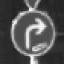

In [7]:
id = 7000
print(data_df.iloc[id])
cv2_imshow(imgs[id])

In [8]:
mu = imgs.mean(axis=(0)) # finds mean of R, G and B separately
std = imgs.std(axis=(0)) # same for std
X_norm = (imgs - mu)/std
print(mu, std)

[[100.61604625 100.53496898 100.82346306 ... 100.99224478 100.46630006
  100.27382967]
 [100.57769318 100.57600113 100.89523407 ... 100.87972363 100.34588268
  100.2178511 ]
 [100.5143824  100.6500282  100.77171461 ... 100.571348   100.1250705
  100.03130288]
 ...
 [ 80.41708968  80.26931754  80.27735477 ...  80.0929216   80.21122391
   80.28102087]
 [ 80.25846024  80.07120699  80.19768754 ...  79.4000282   79.62182741
   79.82727016]
 [ 80.04596729  79.77777778  79.85575296 ...  79.32529611  79.59362662
   79.83784546]] [[80.41732441 80.4770887  80.87924279 ... 81.56738204 81.21511177
  81.11529245]
 [80.41388652 80.2359799  80.61217164 ... 81.09565248 80.75854299
  80.72399448]
 [80.58710079 80.39118909 80.34095544 ... 80.93435164 80.8454062
  80.90259217]
 ...
 [69.72132532 69.36717579 69.32974928 ... 69.74090896 69.76949962
  70.05241866]
 [69.48857291 69.12010954 69.13289886 ... 69.34960123 69.56327562
  69.93221822]
 [69.29780243 68.80361651 68.91858189 ... 69.34898966 69.6431327

In [9]:
X_norm.shape

(7092, 64, 64)

In [10]:
img_shape = imgs[0].shape
img_shape

(64, 64)

In [11]:
#y = data_df.apply(lambda row: [np.where(row.values[1:num_classes+1] == 1)[0][0]], axis=1)
#y = data_df.apply(lambda row: np.where(row.values[1:num_classes+1] == 1)[0][0], axis=1)
y = data_df.apply(lambda row: row.values[1:num_classes+1], axis=1)

In [12]:
y = np.array(list(y),dtype=bool)

In [13]:
y[id]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False])

In [14]:
y_label = np.array(list([[l.argmax()]for l in y]))
y_label.shape

(7092, 1)

In [17]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

In [18]:
x = Input(shape=(img_shape[0],img_shape[1],3 if len(img_shape) == 3 else 1))

c1 = Conv2D(60, (5, 5), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('tanh')(b1)

c2 = Conv2D(60, (5, 5), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('tanh')(b2)

p3 = MaxPooling2D(pool_size=2)(a2)

c4 = Conv2D(30, (5, 5), strides=(1, 1), padding="valid")(p3)
b4 = BatchNormalization()(c4)
a4 = Activation('tanh')(b4)

c5 = Conv2D(30, (5, 5), strides=(1, 1), padding="same")(a4)
b5 = BatchNormalization()(c5)
a5 = Activation('tanh')(b5)

p6 = MaxPooling2D(pool_size=2, padding="same")(a5)
d6 = Dropout(rate=0.5)(p6)
f6 = Flatten()(d6)

h7 = Dense(500)(f6)
b7 = BatchNormalization()(h7)
a7 = Activation('tanh')(b7)


h8 = Dense(500)(a7)
b8 = BatchNormalization()(h8)
a8 = Activation('softmax')(b8)
d8 = Dropout(rate=0.5)(a8)

z = Dense(num_classes)(d8)
p = Activation('softmax')(z)
model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 60)        1560      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 60)       240       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 60)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 60)        90060     
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 60)       240       
 hNormalization)                                             

In [20]:
history = model.fit(X_norm,y_label, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
178/178 [==============================] - 8s 27ms/step - loss: 3.2883 - accuracy: 0.3964 - val_loss: 3.1508 - val_accuracy: 0.6476
Epoch 2/20
178/178 [==============================] - 4s 24ms/step - loss: 3.1224 - accuracy: 0.5704 - val_loss: 2.9090 - val_accuracy: 0.8083
Epoch 3/20
178/178 [==============================] - 4s 24ms/step - loss: 2.9339 - accuracy: 0.6681 - val_loss: 2.6626 - val_accuracy: 0.8774
Epoch 4/20
178/178 [==============================] - 4s 24ms/step - loss: 2.7370 - accuracy: 0.7430 - val_loss: 2.4051 - val_accuracy: 0.9126
Epoch 5/20
178/178 [==============================] - 4s 24ms/step - loss: 2.5259 - accuracy: 0.7879 - val_loss: 2.1392 - val_accuracy: 0.9401
Epoch 6/20
178/178 [==============================] - 4s 24ms/step - loss: 2.3131 - accuracy: 0.8146 - val_loss: 1.8787 - val_accuracy: 0.9556
Epoch 7/20
178/178 [==============================] - 4s 23ms/step - loss: 2.1177 - accuracy: 0.8230 - val_loss: 1.6505 - val_accuracy: 0.9584

Text(0.5, 1.0, 'Accuracy')

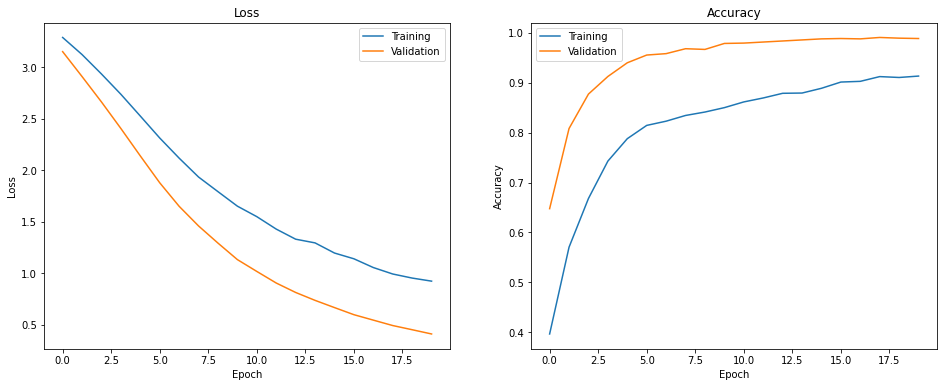

In [21]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

shape (64, 64)
expected class:  Turn right ahead label_id: 27


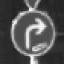

In [33]:
print('shape',X_norm[id].shape)
#print(data_df.iloc[id])
expected_class = data_df.iloc[id].values[1:num_classes+1].argmax()
print('expected class:',data_df.columns[expected_class+1],'label_id:',expected_class)
cv2_imshow(imgs[id])

In [34]:
model.predict(np.array([X_norm[id]])).argmax()

1/1 [==============================] - 0s 17ms/step


27

In [27]:
# find best parameters with CV

In [28]:
# train model

In [29]:
# test model